# Model

In [590]:
# fix relative import
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [591]:
import torch

In [592]:
# ConvBlock
from crepe.model import ConvBlock
convBlock = ConvBlock(
    in_channels=3,   # Number of input channels
    out_channels=6,  # Number of output channels
    kernel_width=4,  # Width of the convolution kernel
    stride=2         # Stride of the convolution
)
expected = """ConvBlock(
  (layer): Sequential(
    (0): ZeroPad2d((0, 0, 1, 2))
    (1): Conv2d(3, 6, kernel_size=(4, 1), stride=(2, 2))
    (2): ReLU()
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
)"""
print("** convBlock **")
print("layers: ")
print(str(convBlock))
print(f"verification: {(str(convBlock)==expected)}")

** convBlock **
layers: 
ConvBlock(
  (layer): Sequential(
    (0): ZeroPad2d((0, 0, 1, 2))
    (1): Conv2d(3, 6, kernel_size=(4, 1), stride=(2, 2))
    (2): ReLU()
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
)
verification: True


In [593]:
# Import crepe
from crepe.model import Crepe

device = torch.device('cuda' if torch.cuda.is_available(
) else 'mps' if torch.backends.mps.is_available() else 'cpu')

crepe = Crepe(model_capacity='tiny', device=device)

print(f"crepe device: ", crepe.device)
print(f"crepe model_capacity: ", crepe.model_capacity)


crepe device:  cuda
crepe model_capacity:  tiny


In [594]:
# load fake audio to crepe (randn)
from crepe.dataset import MIR1KDataset
mir_1k = MIR1KDataset(root_dir=os.path.join(dir1, "dataset/MIR-1K"))

sr = 16000
idx = int(torch.randint(0, int(len(mir_1k)), (1,)))
audio = mir_1k[idx][0]
labels = mir_1k[idx][1]

audio = (audio - torch.mean(audio) ) / (torch.max(audio))
print("audio test")
print(f"load audio MIR 1K id_{idx}")
print(f"sr: {sr} Hz")
print(f"audio shape: {audio.shape}")

time, frequency, confidence, activation = crepe.predict(
    audio=audio,
    sr = sr
)
print("\nProcess..")
print(f"activation Shape: {activation.shape}")
print(f"confidence Shape: {frequency.shape}")
print(f"frequency Shape:  {frequency.shape}")
print(f"time Shape:       {frequency.shape}")


audio test
load audio MIR 1K id_826
sr: 16000 Hz
audio shape: torch.Size([99841])

Process..
activation Shape: torch.Size([625, 360])
confidence Shape: torch.Size([625])
frequency Shape:  torch.Size([625])
time Shape:       torch.Size([625])


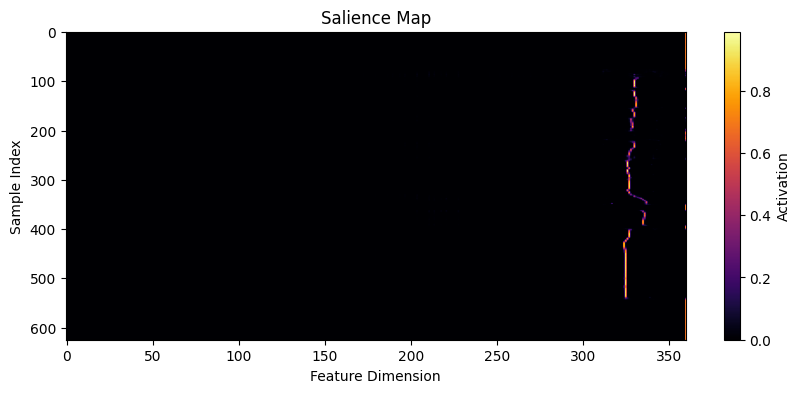

In [595]:
import matplotlib.pyplot as plt
%matplotlib inline

salience = activation.flip(1)
plt.figure(figsize=(10, 4))  # Adjust the figure size
plt.imshow(salience.detach().numpy(), cmap='inferno', aspect='auto')
plt.colorbar(label='Activation')  # Add a color bar for reference
plt.title('Salience Map')
plt.xlabel('Feature Dimension')
plt.ylabel('Sample Index')
plt.show()

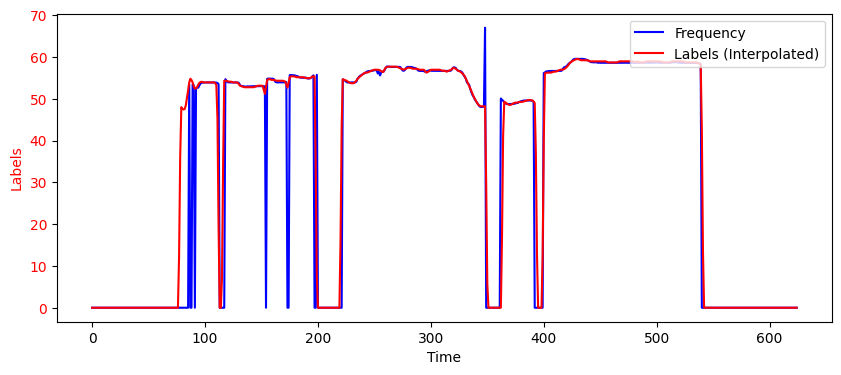

In [596]:
import torch
import matplotlib.pyplot as plt

# Assuming frequency and labels are PyTorch tensors
frequency_np = frequency.detach().numpy()

# Interpolate labels to match the size of frequency
labels_resized = torch.nn.functional.interpolate(
    labels.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
    size=frequency.shape[0],            # Target size
    mode='linear', align_corners=True   # Linear interpolation
).squeeze(0).squeeze(0)  # Remove the added dimensions

labels_np = labels_resized.detach().numpy()

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot frequency on the primary y-axis
ax1.plot(frequency_np, color='b', label='Frequency')
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency (Hz)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax1.plot(labels_np, color='r', label='Labels (Interpolated)')
ax1.set_ylabel('Labels', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Add legends for clarity
ax1.legend(loc='upper left')
ax1.legend(loc='upper right')

# Show the plot
plt.show()
